In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import time
import scipy
import pickle


from multiprocess import Pool
from multiprocess import Process


warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

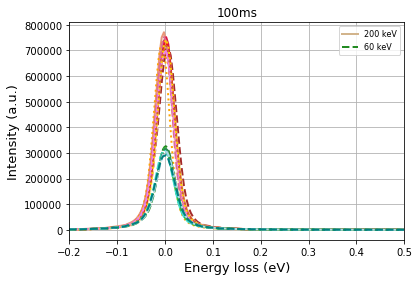

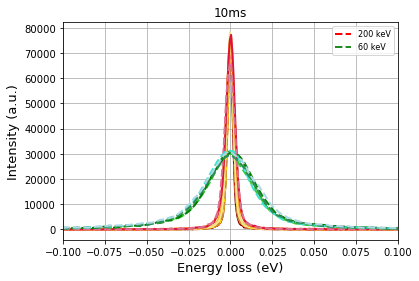

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y7,y8,y9,y10,y11,y12,y13,y14,time,energy
0,-0.954367,-0.944701,-0.937729,-0.958633,-0.948669,-0.849981,-0.849981,-0.923697,-0.923995,-0.923974,...,92.20340,105.04800,13.45050,12.18790,155.20100,85.3088,63.73150,112.94600,100,200
1,-0.949700,-0.940104,-0.933188,-0.953899,-0.944007,-0.845943,-0.845943,-0.919090,-0.919584,-0.919522,...,78.92470,74.33620,25.23600,49.73030,50.40090,56.2916,2.69122,9.44138,100,200
2,-0.945034,-0.935507,-0.928647,-0.949165,-0.939345,-0.841906,-0.841906,-0.914483,-0.915173,-0.915070,...,2.07308,-61.09940,43.59180,7.21912,64.60960,-13.0748,-26.52960,-4.13263,100,200
3,-0.940368,-0.930910,-0.924106,-0.944431,-0.934683,-0.837868,-0.837868,-0.909876,-0.910763,-0.910618,...,-81.36660,19.94870,3.99171,-96.36250,19.54320,63.6954,-49.04250,100.48400,100,200
4,-0.935701,-0.926313,-0.919565,-0.939697,-0.930021,-0.833830,-0.833830,-0.905269,-0.906352,-0.906166,...,-29.48940,44.42410,11.74030,25.47450,-2.63605,21.0576,57.26170,80.27130,100,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,8.579001,8.447313,8.339865,8.712997,8.575721,7.399130,7.399130,8.488369,8.087052,8.171466,...,-57.73360,-30.63200,-63.48630,-94.41850,19.38750,-87.4528,-59.78820,-89.61530,100,200
2044,8.583668,8.451910,8.344406,8.717731,8.580383,7.403168,7.403168,8.492976,8.091463,8.175918,...,-43.72820,-42.44820,2.59805,-44.51020,7.85684,73.2205,-27.22800,69.37240,100,200
2045,8.588334,8.456507,8.348947,8.722465,8.585045,7.407206,7.407206,8.497583,8.095873,8.180370,...,-47.30900,-69.28850,-138.34900,-37.34680,-22.39200,-33.2063,-32.43110,18.32600,100,200
2046,8.593000,8.461104,8.353488,8.727199,8.589707,7.411243,7.411243,8.502190,8.100284,8.184822,...,-96.15140,41.74130,-70.35200,-64.79110,-26.25640,-113.8630,-73.95380,16.47460,100,200


In [9]:
%run EELS-ZLP-Mar.py

file100_200


In [10]:
## Drop all data between FWHM and end

,x,y,sigma,time,energy
count,340.000000,340.000000,340.000000,340.000000,340.000000
mean,0.529412,0.181131,0.017697,0.470588,1.423529
std,0.741035,0.190665,0.030125,0.443590,0.690030
min,-0.100000,0.099861,0.000700,0.100000,0.600000
25%,-0.023077,0.100000,0.001472,0.100000,0.600000
50%,0.054701,0.100217,0.018873,0.100000,2.000000
75%,1.275862,0.140010,0.020000,1.000000,2.000000
max,2.000000,0.949365,0.327638,1.000000,2.000000


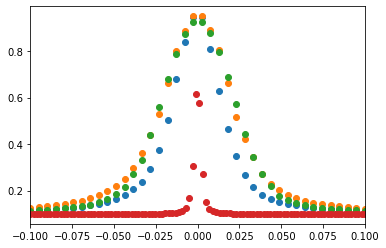

In [11]:
%run Functions.ipynb
meanfile = pd.DataFrame()
from copy import copy
mean = []
columns = ['x', 'y', 'time', 'energy']

file10_60 = pd.read_csv('Data/Vacuum/Datafiles/10_60_total.csv', skiprows = 1, names=columns)
file100_60 = pd.read_csv('Data/Vacuum/Datafiles/100_60_total.csv', skiprows = 1, names=columns)
file10_200 = pd.read_csv('Data/Vacuum/Datafiles/10_200_total.csv', skiprows = 1, names=columns)
file100_200 = pd.read_csv('Data/Vacuum/Datafiles/100_200_total.csv', skiprows = 1, names=columns)

for i, file in enumerate([file10_60, file100_60, file100_200, file10_200]):
    E_min = -.1
    E_max = 0.1
   
    window_file = file[(file['x'] > E_min) & (file['x'] < E_max)]
    window_file['y_norm'] = np.divide(window_file['y'], window_file['y'].max())
    window_file['y_scaled'] = (window_file['y_norm'])*((8/9))+.1
    
    if i == 3:
        nbins = 100
        
    else:
        nbins = 40
        
        
    meanfile = pd.DataFrame()
    meanfile['x'] = np.linspace(E_min, E_max, nbins)
    meanfile['y'] = binned_statistics(window_file['x'], window_file['y_scaled'], nbins)[0]
    meanfile['sigma'] = binned_statistics(window_file['x'], window_file['y_scaled'], nbins)[1]

    meanfile['time'] = file['time'].max()/100
    meanfile['energy'] = file['energy'].max()/100
    
    meanfile['sigma'][meanfile['sigma'] < .0007] = .0007
    time=file['time']/100
    energy = file['energy']/100
    ## Create pseudo data 
    min_x = dE2 = 1
    max_x = 2
    N_pseudo = 30

    df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': .1 * np.ones(N_pseudo), \
                        'sigma': .02 * np.ones(N_pseudo), 'time': time.max(), 'energy': energy.max()})

    df_full = pd.concat([meanfile, df_pseudo])

    df_full.describe()
    ###########
    
    plt.plot(df_full['x'],df_full['y'], 'o')
    #plt.fill_between(df_full['x'], df_full['y']+df_full['sigma'],df_full['y']-df_full['sigma'], alpha=.2)
    plt.xlim([-.1, .1])
    
    mean.append(df_full)
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

total_mean = pd.concat(mean, axis=0, ignore_index=True)


total_mean.describe()

### Create architecture

In [12]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [13]:
tf.compat.v1.get_default_graph
from copy import copy
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
%run Functions.ipynb

x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_full = total_mean
#df_full = df_full.drop_duplicates(subset=['y'])
df_full = df_full.sort_values(by='x')
predictions = make_model(x,1)

df_full.describe()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


,x,y,sigma,time,energy
count,340.000000,340.000000,340.000000,340.000000,340.000000
mean,0.529412,0.181131,0.017697,0.470588,1.423529
std,0.741035,0.190665,0.030125,0.443590,0.690030
min,-0.100000,0.099861,0.000700,0.100000,0.600000
25%,-0.023077,0.100000,0.001472,0.100000,0.600000
50%,0.054701,0.100217,0.018873,0.100000,2.000000
75%,1.275862,0.140010,0.020000,1.000000,2.000000
max,2.000000,0.949365,0.327638,1.000000,2.000000


In [14]:
df_train, df_test = train_test_split(df_full, test_size=0.2)

cols=[ 'x', 'time', 'energy', 'sigma']
train_inputs = df_train.drop(['y'], axis=1)[cols]
train_outputs = df_train['y']
test_inputs = df_test.drop(['y'], axis=1)[cols]
test_outputs = df_test['y']

train_x = train_inputs.drop('sigma', axis=1).to_numpy()
train_y = train_outputs.to_numpy()
train_sigma = train_inputs['sigma'].to_numpy()
test_x = test_inputs.drop('sigma', axis=1).to_numpy()
test_y = test_outputs.to_numpy()
test_sigma = test_inputs['sigma'].to_numpy()

df_test.describe()

train_sigma.shape


(272,)

## Create MC replicas

In [15]:
### Create array of Nrep training samples
Nrep = 5000
N_train = len(train_y)
N_test = len(test_y)

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)



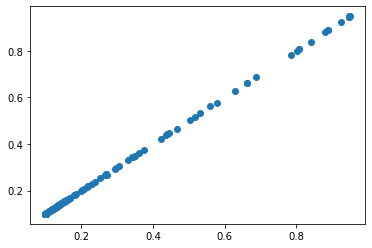

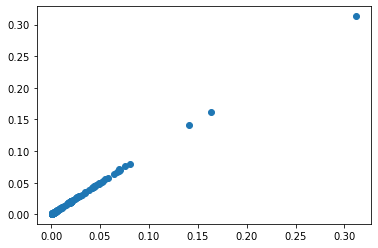

In [16]:
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')

In [17]:
## Beam energy interpolation

import random

part1 = 1000
N_pred = 10 * part1

interpol_energy1 = .2 #*100 keV
interpol_energy2 = .4 #*100 keV
interpol_energy3 = .6
interpol_energy4 = .8
interpol_energy5 = 1.2
interpol_energy6 = 1.8
interpol_energy7 = 2
interpol_energy8 = 2.2
interpol_energy9 = 2.5
interpol_energy10 = 3

interpol_time = .1
E_min = -.8
E_max = -.1

#Energy --> Energy range veranderen zodat het alleen interpolatie doet op E. 
predict_x = np.zeros(shape=(N_pred, 3))
predict_x[0*part1:1*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[1*part1:2*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[3*part1:4*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[4*part1:5*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[5*part1:6*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[6*part1:7*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[7*part1:8*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[8*part1:9*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[9*part1:10*part1, 0] = np.linspace(E_min,E_max,part1)

#Time
predict_x[:,1] = interpol_time * np.ones(N_pred)

# E_beam
predict_x[0*part1:1*part1,2] = interpol_energy1 * np.ones(part1)
predict_x[1*part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:4*part1,2] = interpol_energy4 * np.ones(part1)
predict_x[4*part1:5*part1,2] = interpol_energy5 * np.ones(part1)
predict_x[5*part1:6*part1,2] = interpol_energy6 * np.ones(part1)
predict_x[6*part1:7*part1,2] = interpol_energy7 * np.ones(part1)
predict_x[7*part1:8*part1,2] = interpol_energy8 * np.ones(part1)
predict_x[8*part1:9*part1,2] = interpol_energy9 * np.ones(part1)
predict_x[9*part1:10*part1,2] = interpol_energy10 * np.ones(part1)

predict_x2 = copy(predict_x)
predict_x2[:,1] = 1 * np.ones(N_pred)
predict_x = np.vstack([predict_x, predict_x2])

In [18]:
predict_x.shape
N_pred = len(predict_x[:,0])


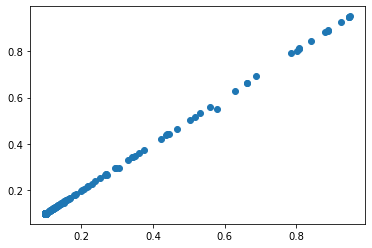

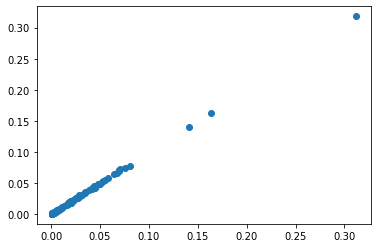

In [19]:
Nrep = 1000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train,)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test,)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

train_sigma.shape
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')
plt.show()


In [20]:
import time
from datetime import datetime
now = datetime.now()
import tensorflow.compat.v1 as tf

def function_train(it):
    import tensorflow.compat.v1 as tf
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 8e-3

    #optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False).minimize(cost)

    #optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    saver = tf.compat.v1.train.Saver(max_to_keep=10000)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 100

    for i in range(48,73):
        train_y = train_y_reps[:, i + it].reshape(N_train,1)
        test_y = test_y_reps[:, i + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.compat.v1.Session() as sess:
 
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 50000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma.reshape(N_train,1)
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma.reshape(N_test,1)})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            


            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = '20.08.2020'
            t_string = now.strftime("%H:%M:%S")
            print(d_string)
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s' % {'s': d_string, 'it': it, 'i': i})


            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 

            
            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        

        a = np.array(train_x[:,0]).reshape(N_train,)
        b = np.array(train_x[:,1]).reshape(N_train,)
        c = np.array(train_x[:,2]).reshape(N_train,)
        d = np.array(train_y).reshape(N_train,)
        e = np.array(predictions_values).reshape(N_train,)
        
        f = array_train
        g = array_test
       
        k = np.array(predict_x[:,0]).reshape(N_pred,)
        l = np.array(predict_x[:,1]).reshape(N_pred,)
        m = np.array(predict_x[:,2]).reshape(N_pred,)
        n = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(a,b,c,d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(f,g)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(k, l, m, n)),  delimiter=',', fmt='%f')
 

## File with energy extrapolation

In [89]:
predict = []
time = [.1, 1]
for i, energy in enumerate(np.linspace(0, 300, 31)):
    
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy/100
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


,x,time,energy
count,6.200000e+04,62000.000000,62000.000000
mean,-1.522080e-20,0.550000,1.500000
std,5.779326e-02,0.450004,0.894434
min,-1.000000e-01,0.100000,0.000000
25%,-5.000000e-02,0.100000,0.700000
50%,0.000000e+00,0.550000,1.500000
75%,5.000000e-02,1.000000,2.300000
max,1.000000e-01,1.000000,3.000000


In [90]:
d_string = '20.08.2020'
prediction_file = pd.DataFrame()
prediction_file['x'] = predict_x['x']
prediction_file['time'] = predict_x['time']
prediction_file['energy'] = predict_x['energy']

good_files = np.loadtxt('good_files_vacuum')

In [91]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(0,500):
        
        if good_files[i] == 1:
            best_model = 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s'% {'s': d_string, 'it': 1, 'i': i}
            saver = tf.compat.v1.train.Saver(max_to_keep=1000)
            saver.restore(sess, best_model)
    
            extrapolation = sess.run(predictions,
                                feed_dict={
                                x: predict_x
                                })

            prediction_file['prediction_%(i)s' % {"i": i}] = extrapolation[:,0]
            

#plt.plot(predict_full['x'], predict_full['prediction'], colormap=predict_full['energy'], alpha=.8)   
prediction_file.to_csv('Data/Prediction_vacuum_Ebeam')

INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_0
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_1
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_2
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_3
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_4
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_5
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_6
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_7
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_8
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_9
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_10
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_100
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_101
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_102
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_103
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_104
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_105
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_106
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_107
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_108
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_110
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_111
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_194
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_195
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_196
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_197
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_198
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_199
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_200
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_201
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_202
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_203
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_204
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_287
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_288
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_289
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_290
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_291
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_292
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_293
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_294
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_295
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_296
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_297
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_383
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_384
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_385
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_386
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_387
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_388
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_389
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_390
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_391
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_392
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_393
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_478
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_479
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_480
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_481
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_482
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_483
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_484
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_485
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_487
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_488
INFO:tensorflow:Restoring parameters from Models/Best_model/20.08.2020/x1_processor1_489
INFO:tensorflow:Resto

## Energy extrapolation plot

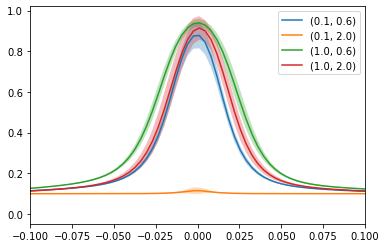

In [46]:
energy_file = pd.read_csv('Data/Prediction_vacuum_energy')

groups = energy_file.groupby(['time', 'energy'])

ax = plt.subplots((1))

for name, group in groups:
    mean_prediction = group.iloc[:, 4:].mean(axis=1)
    std_prediction = group.iloc[:, 4:].std(axis=1)
    plt.plot(group.x, (mean_prediction), label=name)
    plt.fill_between(group.x, mean_prediction + std_prediction, mean_prediction - std_prediction, alpha=.3)
    plt.legend()
    plt.xlim([-.1, .1])
    

In [92]:
ebeam_file = pd.read_csv('Data/Prediction_vacuum_Ebeam')

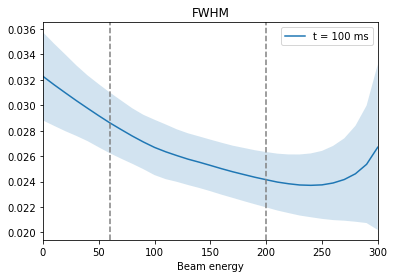

In [148]:
groups_time = ebeam_file.groupby(['time'])
ax = plt.subplots((1))

for name, group in groups_time:
    groups_energy = group.groupby(['energy'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    
    for name_energy, group_energy in groups_energy:
        fwhm_array = []
        max_array = []
        
        
        for i in range(4,100):
            prediction = pd.DataFrame({"x": group_energy.x, "pred": group_energy.iloc[:,i]})
            fwhm = prediction['x'][(prediction['x'] > 0) & (prediction['pred'] < prediction['pred'].max()/2)].min()
            maxvalue = prediction['pred'].max()
            max_array.append(maxvalue)
            fwhm_array.append(fwhm)
            
        fwhm_mean = np.mean(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        
        max_mean = np.mean(max_array)
        max_std = np.std(max_array)
        max_means.append(max_mean)
        max_stds.append(max_std)
        
        fwhm_high = np.add(fwhm_means, fwhm_stds)
        fwhm_low = np.subtract(fwhm_means, fwhm_stds)
        
        max_high = np.add(max_means, max_stds)
        max_low = np.subtract(max_means, max_stds)
        
        np.savetxt('Data/Results/maxvalues_mean_%(s)s' % {"s": name}, max_means)
        np.savetxt('Data/Results/maxvalues_std_%(s)s' % {"s": name}, max_stds)
    if group.time.max() == 1:    
        plt.plot(100*group['energy'].unique(), fwhm_means, label='t = 100 ms')
        plt.fill_between(100*group['energy'].unique(), fwhm_high, fwhm_low, alpha=.2)
        plt.xlim([0, 300])
        plt.xlabel('Beam energy')
        plt.legend()
        plt.title('FWHM')
        
        
    
plt.axvline(x=60, linestyle='--', color='gray')
plt.axvline(x=200, linestyle='--', color='gray')
    

Text(0.5, 1.0, 'Maximum intensity')

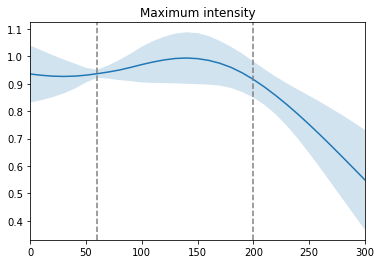

In [150]:
maxvalues_mean_100 = np.loadtxt('Data/Results/maxvalues_mean_1.0')
maxvalues_mean_10 = np.loadtxt('Data/Results/maxvalues_mean_0.1')
maxvalues_std_100 = np.loadtxt('Data/Results/maxvalues_std_1.0')
maxvalues_std_10 = np.loadtxt('Data/Results/maxvalues_std_0.1')

maxvalues_mean_10 = np.multiply(maxvalues_mean_10, (2.5/5)) + .5

up10 = np.add(maxvalues_mean_10, maxvalues_std_10)
up100 = np.add(maxvalues_mean_100, maxvalues_std_100)
low10 = np.subtract(maxvalues_mean_10, maxvalues_std_10)
low100 = np.subtract(maxvalues_mean_100, maxvalues_std_100)


#plt.plot(np.linspace(0,300,31), maxvalues_mean_10)
#plt.fill_between(np.linspace(0,300,31), up10, low10, alpha=.2)
plt.plot(np.linspace(0,300,31), maxvalues_mean_100)
plt.fill_between(np.linspace(0,300,31), up100, low100, alpha=.2)
plt.axvline(x=60, linestyle='--', color='gray')
plt.axvline(x=200, linestyle='--', color='gray')
plt.xlim([0, 300])
plt.title('Maximum intensity')


(0, 300)

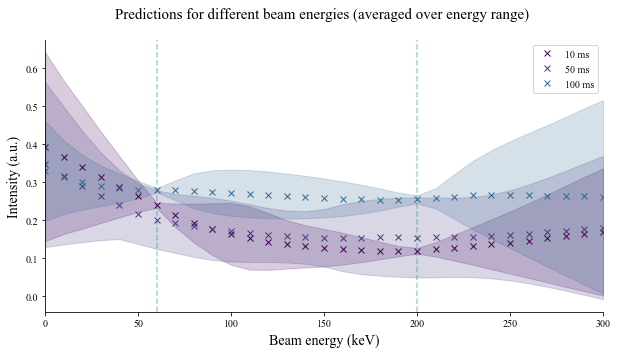

In [379]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,7) 
colors = [ cm.viridis(x) for x in cm_subsection ]

fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.axvline(60, linestyle='--', color=colors[3], alpha=.4)
ax.axvline(200, linestyle='--', color=colors[3], alpha=.4)

i=0
for name, group in groups_time:
    mean_energy = group.groupby('energy').mean()
    ax.plot(100*predict_full['energy'].unique(), mean_energy.pred_mean, 'x', color=colors[i], label=str(round(name*100))+' ms')
    ax.fill_between(100*predict_full['energy'].unique(), mean_energy.pred_mean + mean_energy.pred_std, \
                    mean_energy.pred_mean - mean_energy.pred_std, color=colors[i], alpha=.2 )
    i+=1
    
ax.legend()
ax.set_title('Predictions for different beam energies (averaged over energy range) \n', fontsize=15)
ax.set_xlabel('Beam energy (keV)', fontsize=14)
ax.set_ylabel('Intensity (a.u.)', fontsize=14)
ax.set_xlim([0,300])
 

ValueError: x and y must have same first dimension, but have shapes (31,) and (62,)

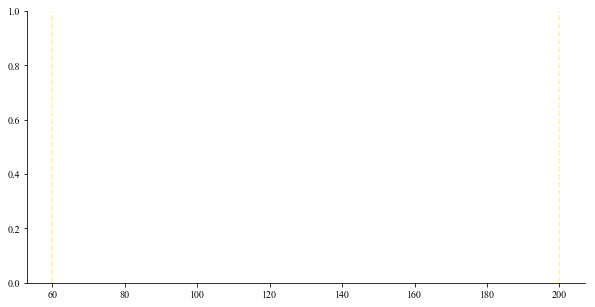

In [244]:
plt.figure(figsize=(10,5))
plt.axvline(60, linestyle='--', color=colors[10], alpha=.4)
plt.axvline(200, linestyle='--', color=colors[10], alpha=.4)


plt.plot(100*predict_full['energy'].unique(), energy_means['pred_mean'], 'x', color=colors[5], label='Mean')
plt.fill_between(100*predict_full['energy'].unique(), energy_means['pred_mean'] + energy_means['pred_std'], \
                 energy_means['pred_mean'] - energy_means['pred_std'], alpha=.2, color = colors[5], label='$\pm \sigma$')
plt.title('Predictions for different beam energies (averaged over energy range) \n', fontsize=15)
plt.xlabel('Beam energy (keV)', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.legend()
plt.xlim([0,300])
energy_means

In [195]:
totalfile = pd.concat(totalfile, energy_means)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

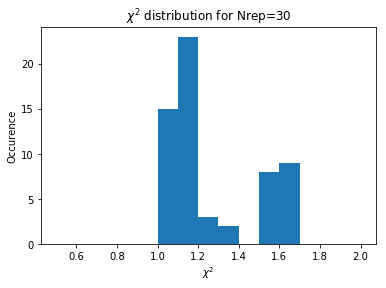

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)